### 1. Download relevant packages and data

In [298]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['SW', 'SOLV', 'GEV', 'VLTO']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close  ...        open       volume
date       ticker                          ...                         
2015-09-29 A        31.425230   33.740002  ...   33.360001    2252400.0
           AAL      37.361629   39.180000  ...   39.049999    7478800.0
           AAPL     24.651134   27.264999  ...   28.207500  293461600.0
           ABBV     36.004154   52.790001  ...   53.099998   12842800.0
           ABT      33.302025   39.500000  ...   39.259998   12287500.0
...                       ...         ...  ...         ...          ...
2023-09-26 XYL      88.736305   89.519997  ...   90.379997    1322400.0
           YUM     122.211014  124.010002  ...  124.239998    1500600.0
           ZBH     111.534821  112.459999  ...  116.769997    3610500.0
           ZBRA    223.960007  223.960007  ...  225.970001     355400.0
           ZTS     175.131134  176.869995  ...  176.580002    1463200.0

[985955 rows x 6 columns]

### 2. Calculate features and technical indicators for each stock.
* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume
\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [299]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close  ...      macd  dollar_volume
date       ticker                          ...                         
2015-09-29 A        31.425230   33.740002  ...       NaN      70.782188
           AAL      37.361629   39.180000  ...       NaN     279.420155
           AAPL     24.651134   27.264999  ...       NaN    7234.161370
           ABBV     36.004154   52.790001  ...       NaN     462.394152
           ABT      33.302025   39.500000  ...       NaN     409.198630
...                       ...         ...  ...       ...            ...
2023-09-26 XYL      88.736305   89.519997  ... -2.159188     117.344890
           YUM     122.211014  124.010002  ... -1.363695     183.389847
           ZBH     111.534821  112.459999  ... -0.881067     402.696470
           ZBRA    223.960007  223.960007  ... -1.600791      79.595386
           ZTS     175.131134  176.869995  ... -1.188278     256.251875

[985955 rows x 14 columns]

### 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.
To reduce training time and experiment with features and strategies, business-daily data is converted to month-end frequency.

In [300]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  ...       atr      macd
date       ticker                             ...                    
2015-11-30 A          135.740910   38.950909  ... -1.033887  0.567158
           AAL        287.915795   39.429928  ...  0.190822 -0.418773
           AAPL      4023.984029   26.854134  ... -0.967900 -0.142790
           ABBV       334.491196   40.025845  ... -0.526809  0.145677
           ABT        210.542062   38.091488  ... -1.064842  0.335557
...                          ...         ...  ...       ...       ...
2023-09-30 OTIS       154.361757   78.356499  ... -1.028320 -1.534536
           ABNB      1633.500725  132.279999  ... -1.006939 -0.037854
           CEG        196.670368  107.862030  ... -0.436215  0.366876
           GEHC       212.197215   66.105721  ... -0.893478 -1.116463
           KVUE       670.804320   20.006195  ... -0.899746 -1.435620

[46553 rows x 9 columns]

Calculate 5 year rolling average of dollar volume for each stocks before filtering

In [301]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol  ...       atr      macd
date       ticker                                ...                    
2016-10-31 AAL      39.134331         -0.000176  ...  0.402199  1.131595
           AAPL     26.212477         -0.002468  ... -1.038688 -0.195978
           ABBV     39.878784         -0.049190  ... -0.893132 -0.760594
           ABT      34.112476         -0.008074  ... -1.035224 -0.650889
           ACN     103.117401         -0.005023  ... -0.996806 -0.135457
...                       ...               ...  ...       ...       ...
2023-09-30 XOM     113.372093         -0.000065  ...  0.601335  1.400623
           MRNA     98.120003          0.000146  ... -0.529511 -0.376899
           UBER     44.270000          0.000441  ... -0.746098 -0.133973
           CRWD    160.479996          0.000144  ... -0.744862  0.245950
           ABNB    132.279999          0.000213  ... -1.006939 -0.037854

[12516 rows x 8 columns]

### 4. Calculate Monthly Returns for different time horizons as features.
To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [302]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol  ...  return_9m  return_12m
date       ticker                                ...                       
2017-10-31 AAL      45.534172         -0.000363  ...   0.007008    0.012702
           AAPL     39.713894         -0.001055  ...   0.038941    0.035228
           ABBV     66.876808         -0.036142  ...   0.047273    0.044026
           ABT      48.237465         -0.005677  ...   0.031320    0.029294
           ACN     128.834686         -0.004274  ...   0.027398    0.018728
...                       ...               ...  ...        ...         ...
2023-09-30 XOM     113.372093         -0.000065  ...   0.008747    0.027037
           MRNA     98.120003          0.000146  ...  -0.064976   -0.015431
           UBER     44.270000          0.000441  ...   0.066838    0.043691
           CRWD    160.479996          0.000144  ...   0.047942   -0.002216
           ABNB    132.279999          0.000213  ...   0.049124    0.019401

[10341 rows x 14 columns]

### 5. Download Fama-French Factors and Calculate Rolling Factor Betas.
We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [303]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0090 -0.0327  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.009617
           VZ     -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.056890
           WFC    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.015500
           WMT    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.000676
           XOM    -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.046947

[10341 rows x 6 columns]

Filter out stocks with less than 10 months of data

In [304]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0090 -0.0327  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.009617
           VZ     -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.056890
           WFC    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.015500
           WMT    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.000676
           XOM    -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.046947

[10314 rows x 6 columns]

Calculate rolling factor betas

In [305]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456089 -0.460026 -0.281339 -0.074279  0.761453
           VZ      0.331581 -0.173420  0.290305  0.315698  0.071478
           WFC     1.119316  0.309055  2.035946 -0.441943 -1.504620
           WMT     0.700666 -0.312947 -0.416686 -0.138962  0.516751
           XOM     0.978566 -1.095948  1.773611 -0.624866 -0.412273

[10314 rows x 5 columns]

In [306]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10095 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10095 non-null  float64
 1   rsi               10095 non-null  float64
 2   bb_low            10095 non-null  float64
 3   bb_mid            10095 non-null  float64
 4   bb_high           10095 non-null  float64
 5   atr               10095 non-null  float64
 6   macd              10095 non-null  float64
 7   return_1m         10095 non-null  float64
 8   return_2m         10095 non-null  float64
 9   return_3m         10095 non-null  float64
 10  return_6m         10095 non-null  float64
 11  return_9m         10095 non-null  float64
 12  return_12m        10095 non-null  float64
 13  Mkt-RF            10095 non-null  float64
 14  SMB               10095 non-null  float64
 15  HML       

### 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
K-Means Clustering


Apply pre-define centroids

In [312]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 19))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]])

In [313]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi  ...       CMA  cluster
date       ticker                               ...                   
2017-10-31 AAL            -0.000363  41.051801  ...  0.574169        1
           AAPL           -0.001055  69.196672  ...  0.458467        3
           ABBV           -0.036142  55.247895  ...  0.183429        2
           ABT            -0.005677  53.844907  ...  0.972082        2
           ACN            -0.004274  69.365272  ...  0.173058        3
...                             ...        ...  ...       ...      ...
2023-09-30 WMT            -0.000041  54.722530  ...  0.651562        2
           XOM            -0.000065  59.440176  ... -0.329148        3
           MRNA            0.000146  38.747314  ...  0.995470        1
           UBER            0.000441  45.005268  ... -0.381346        1
           CRWD            0.000144  51.534803  ... -0.722896        2

[10095 rows x 19 columns]

In [314]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:,1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:,1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:,1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:,1], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return

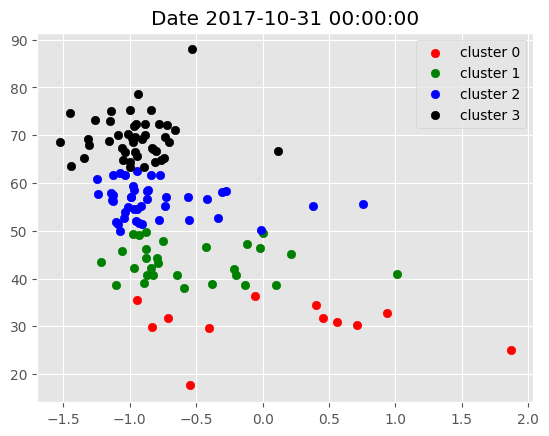

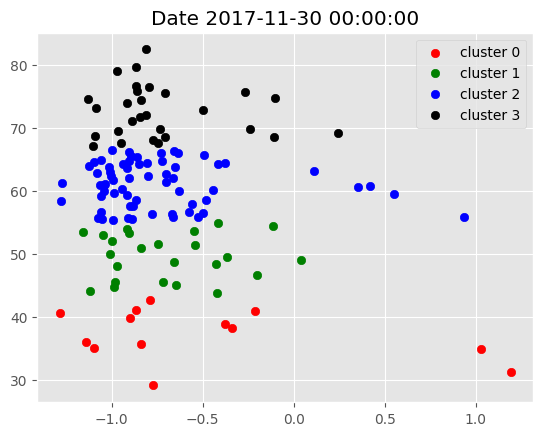

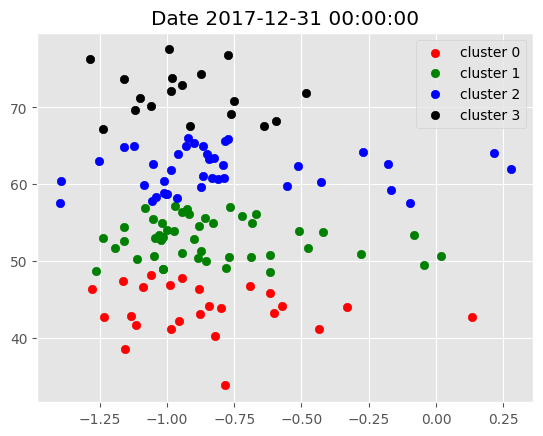

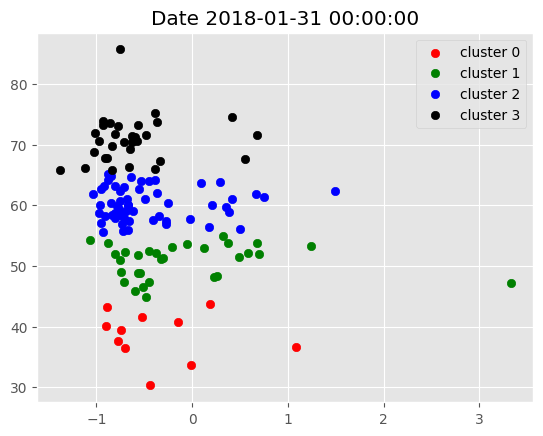

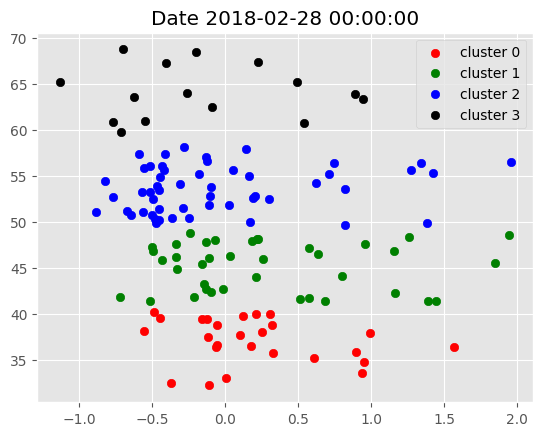

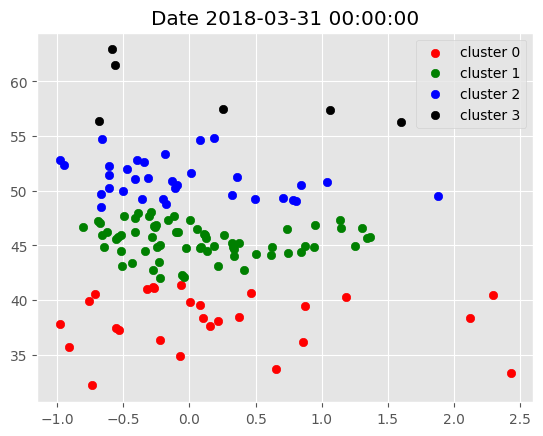

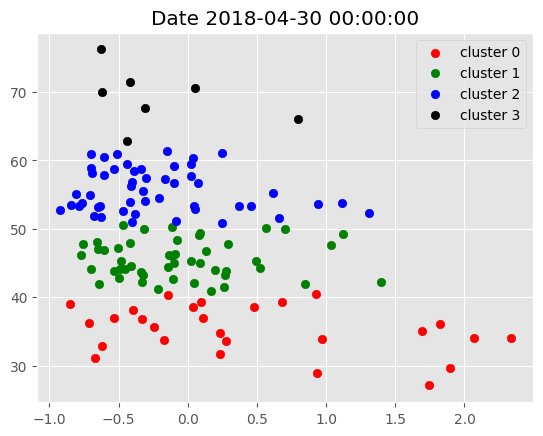

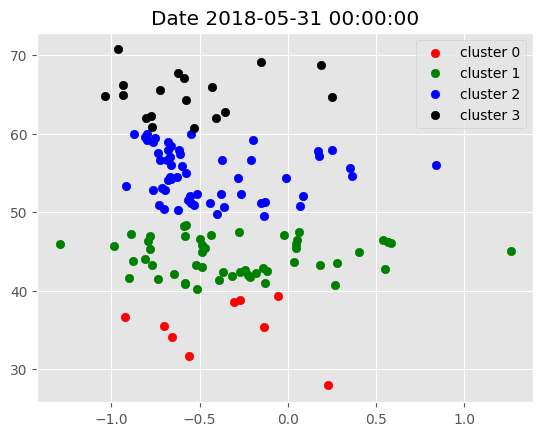

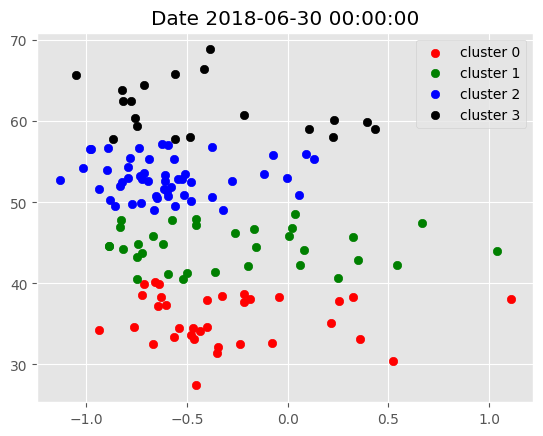

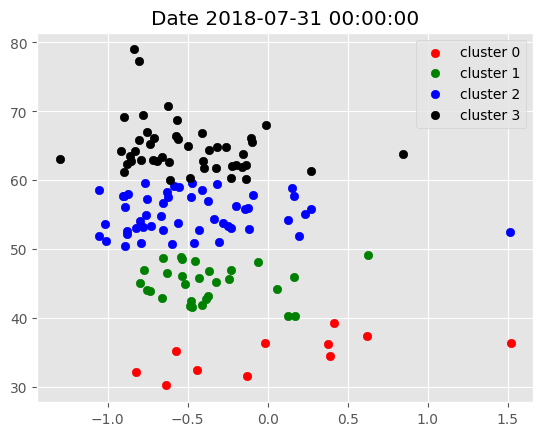

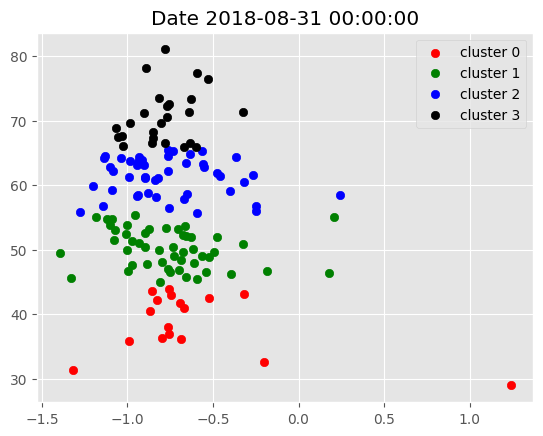

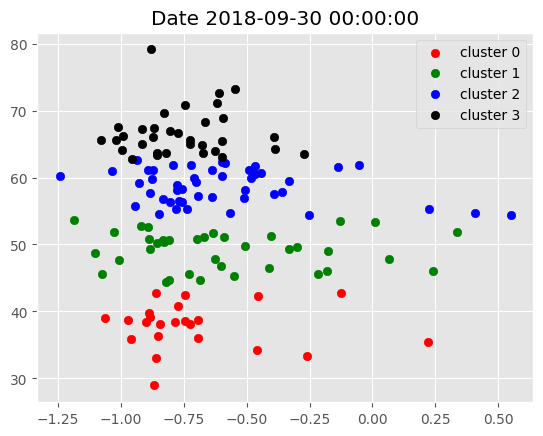

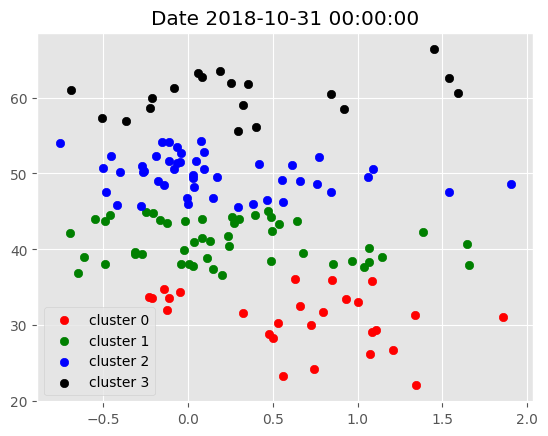

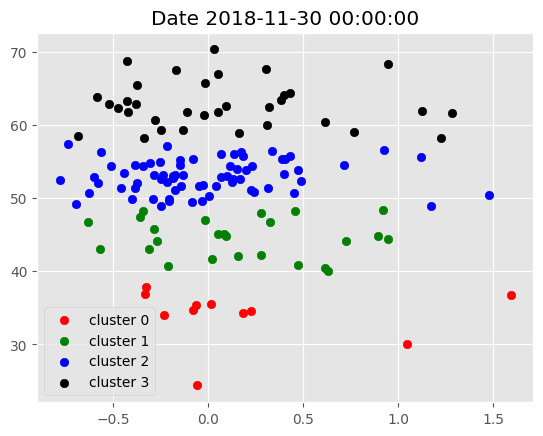

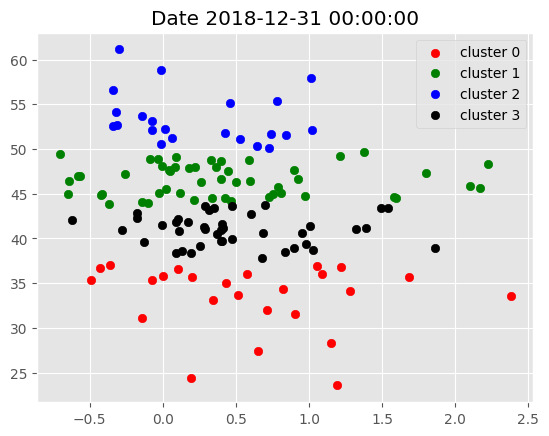

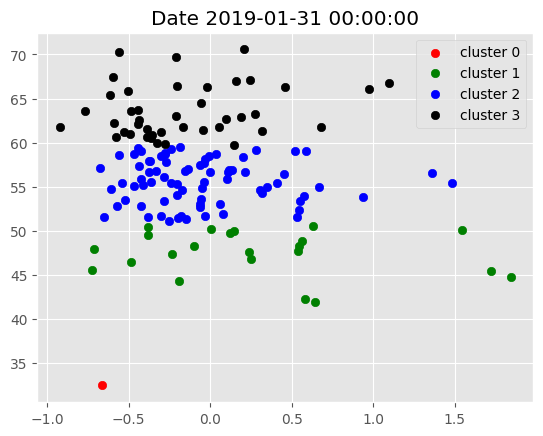

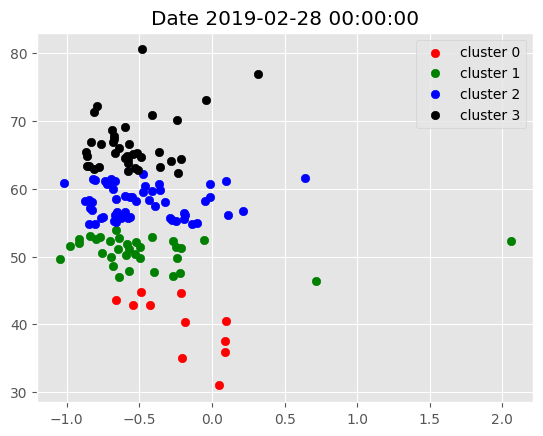

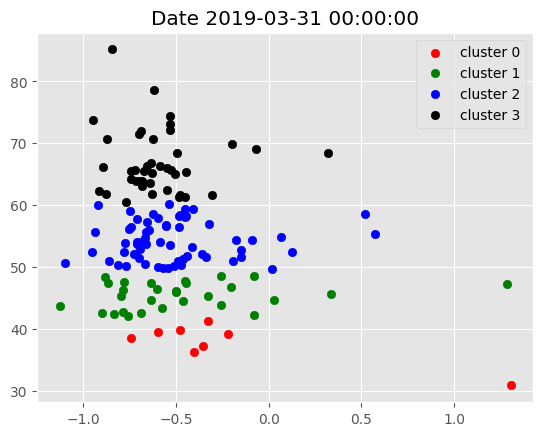

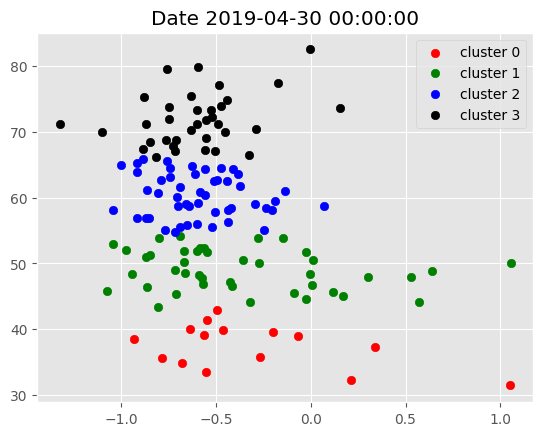

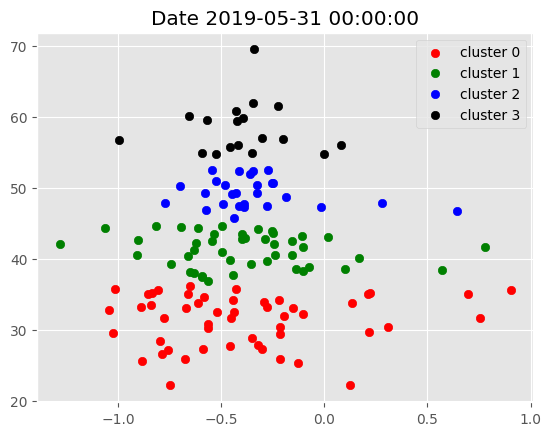

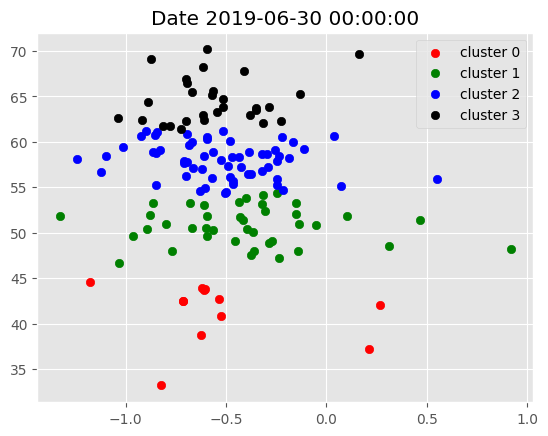

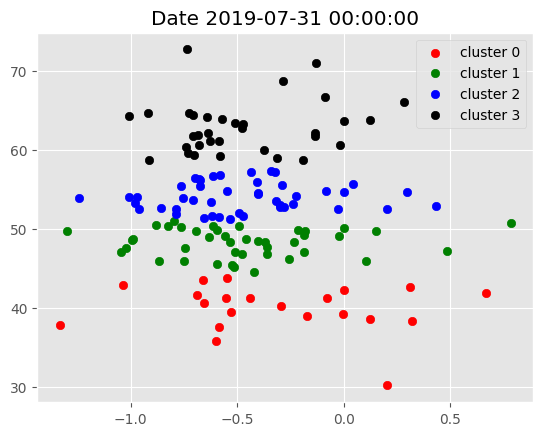

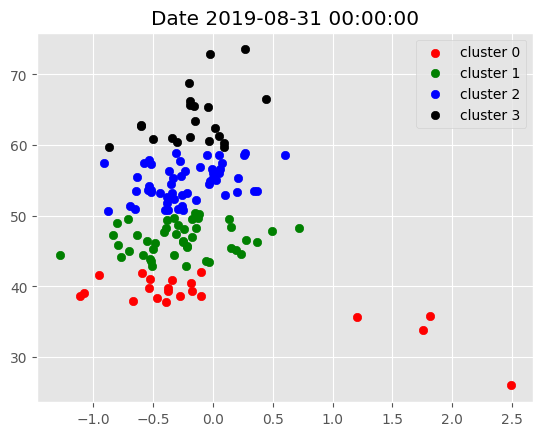

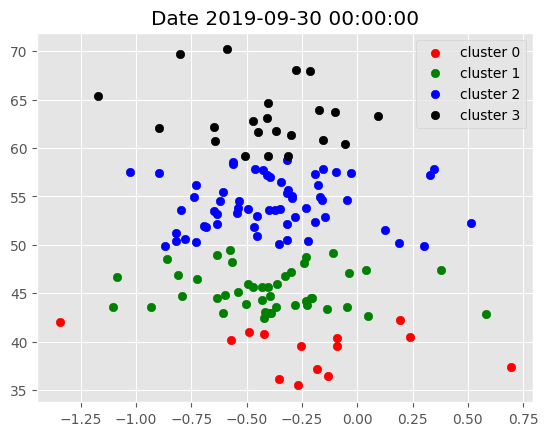

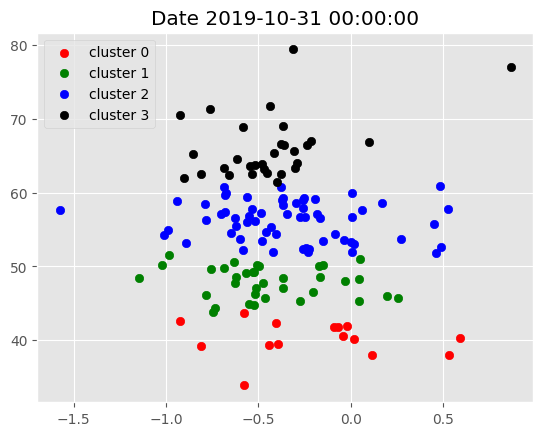

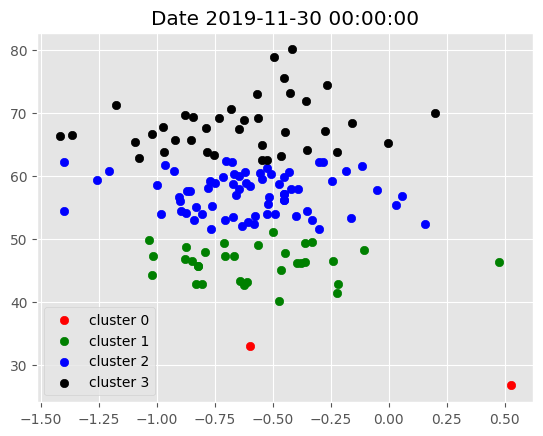

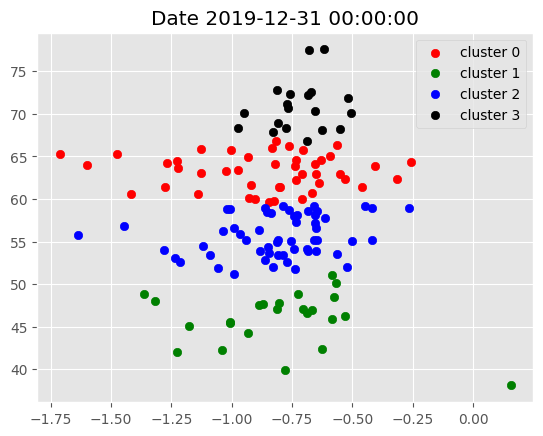

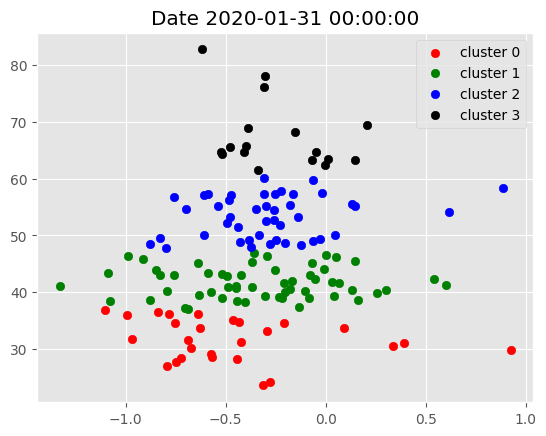

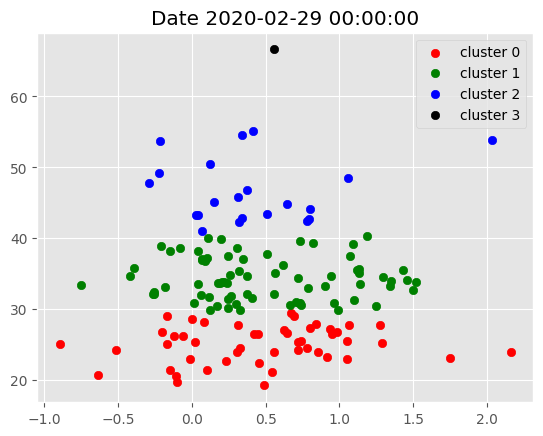

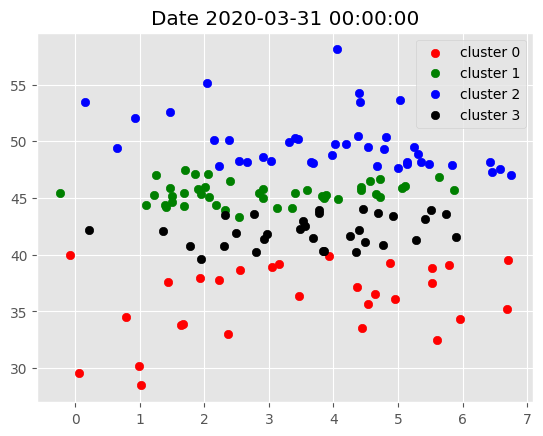

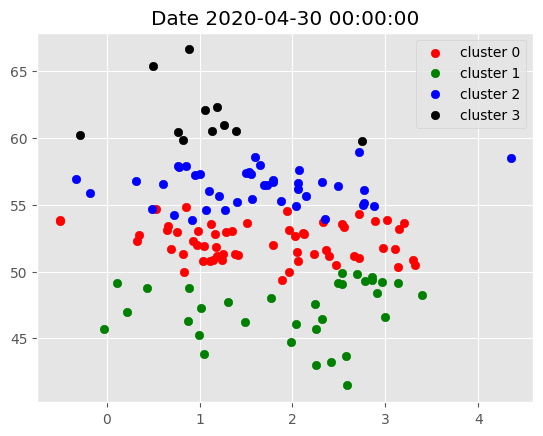

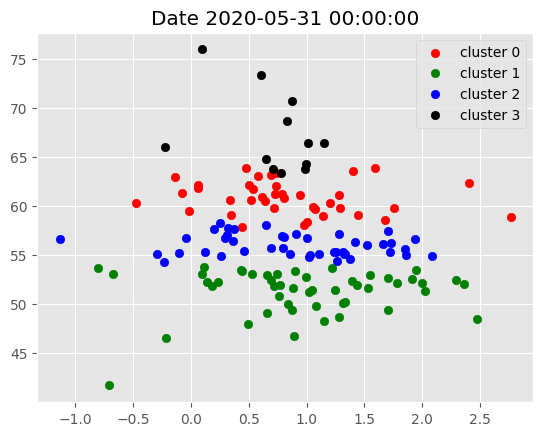

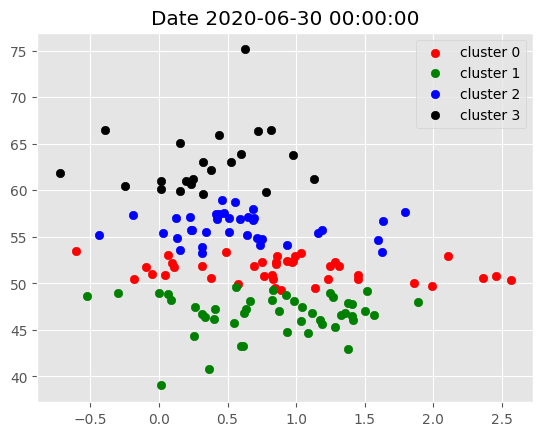

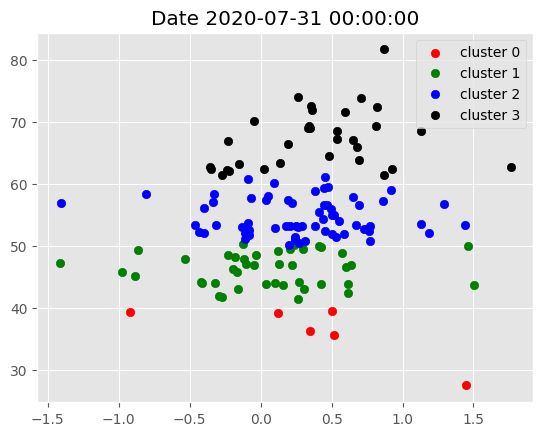

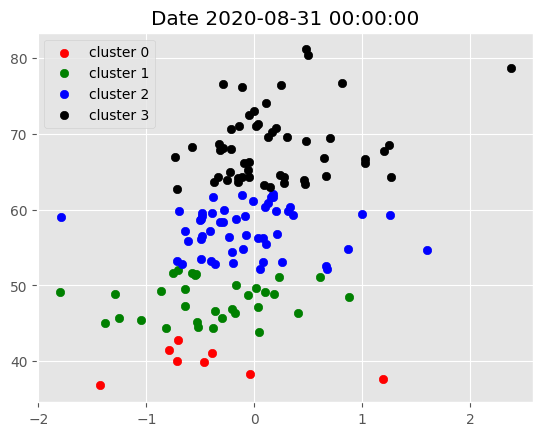

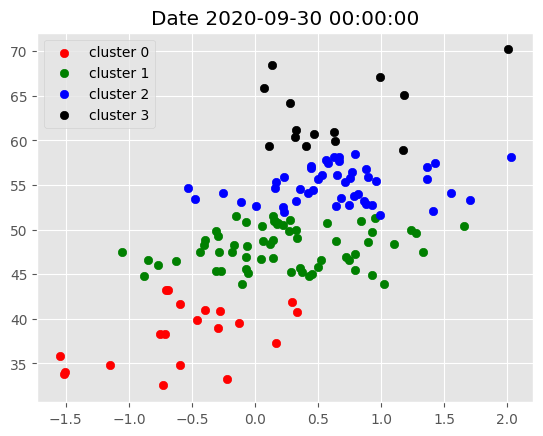

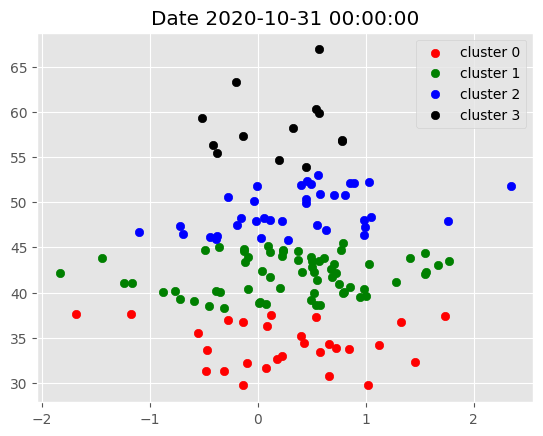

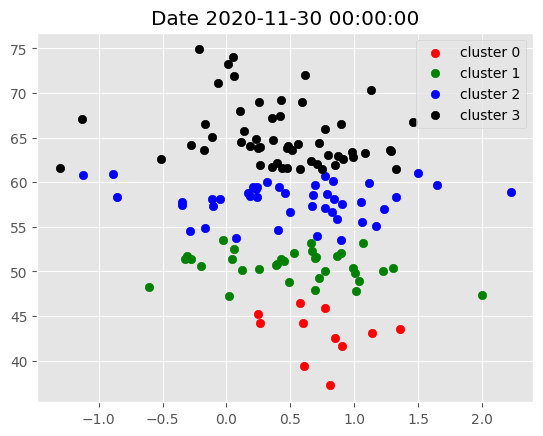

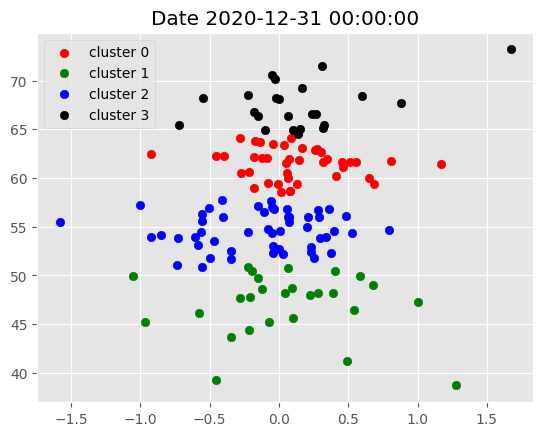

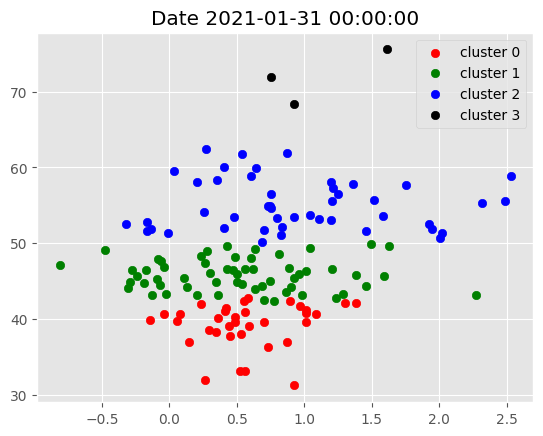

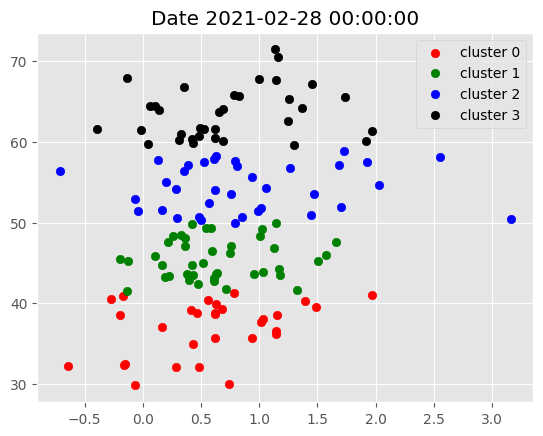

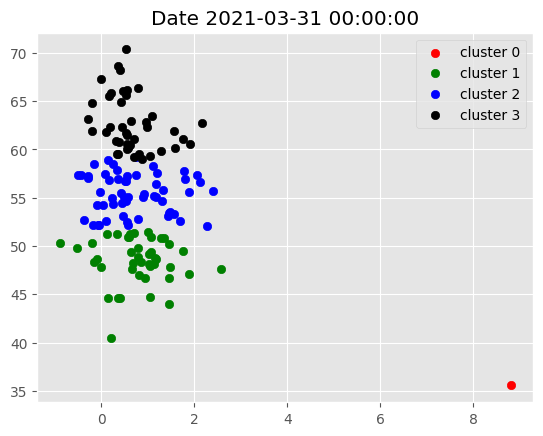

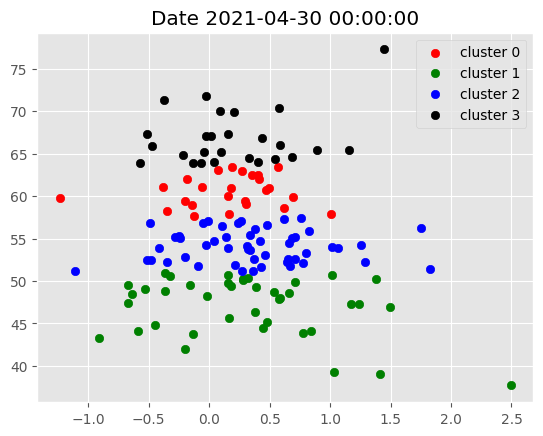

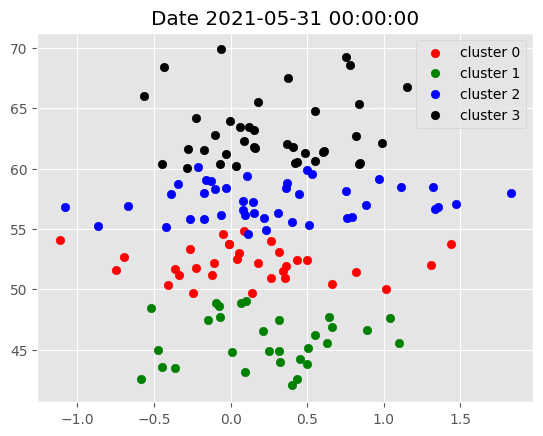

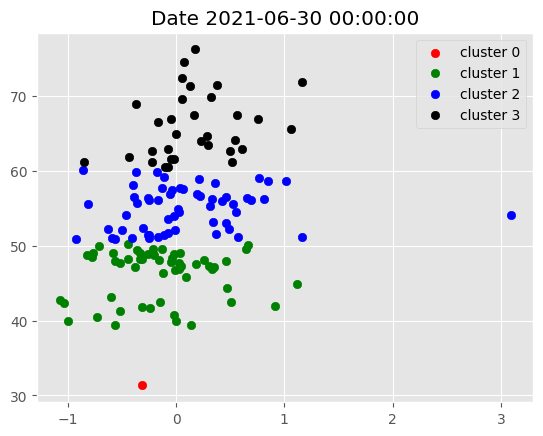

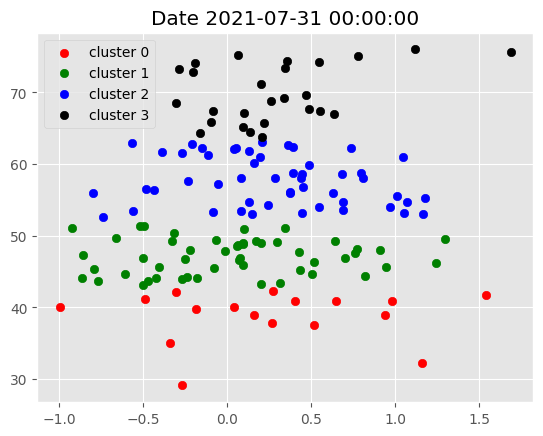

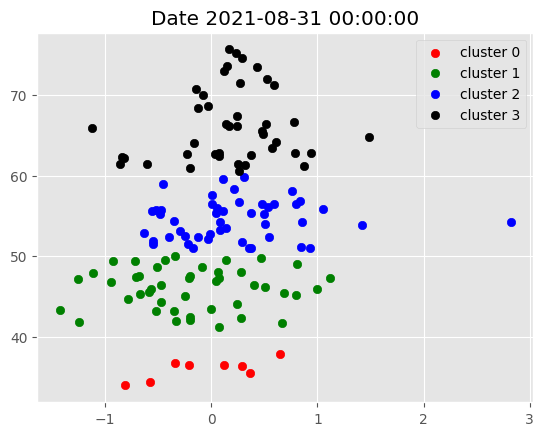

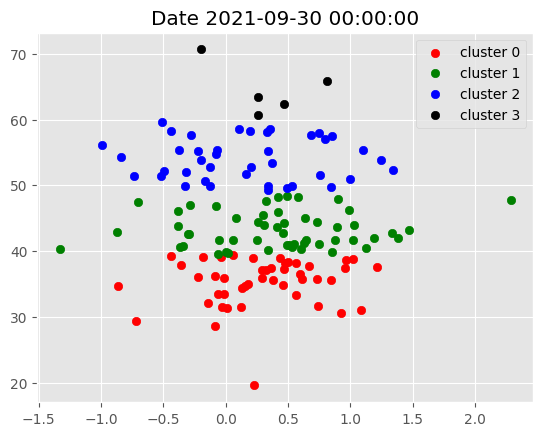

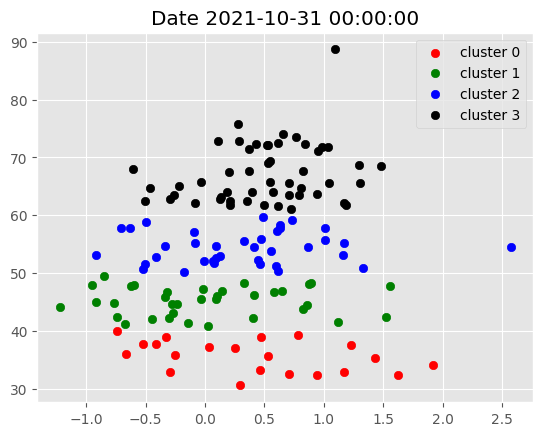

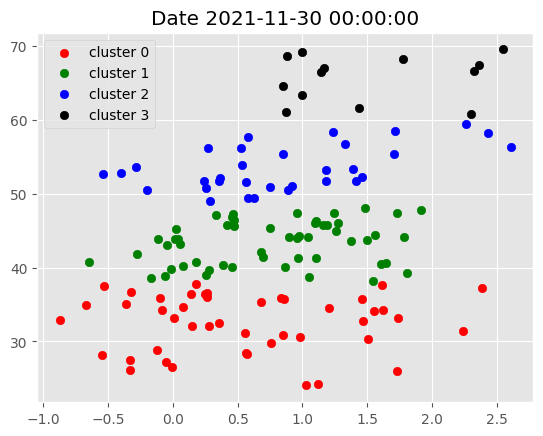

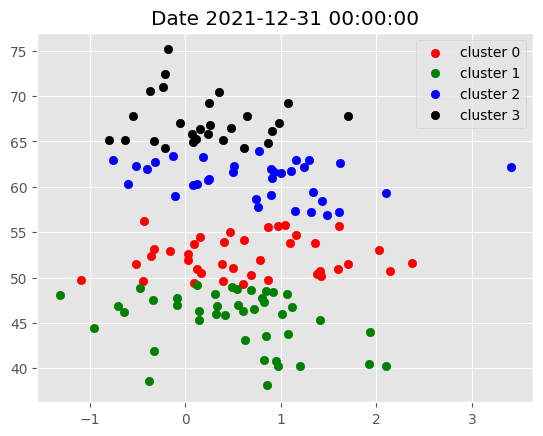

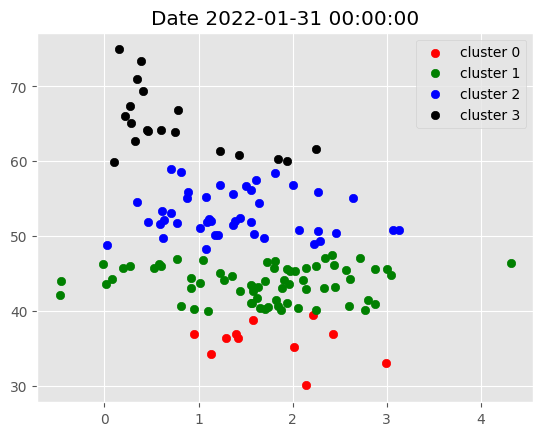

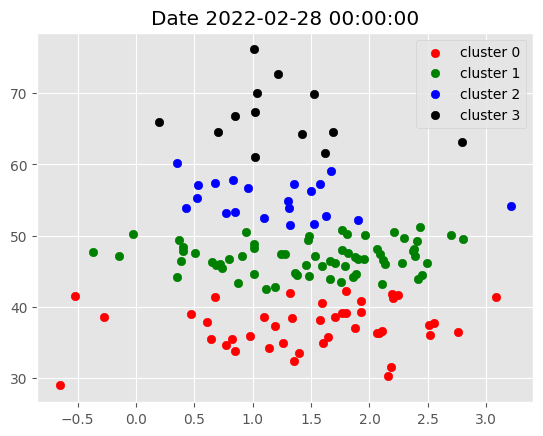

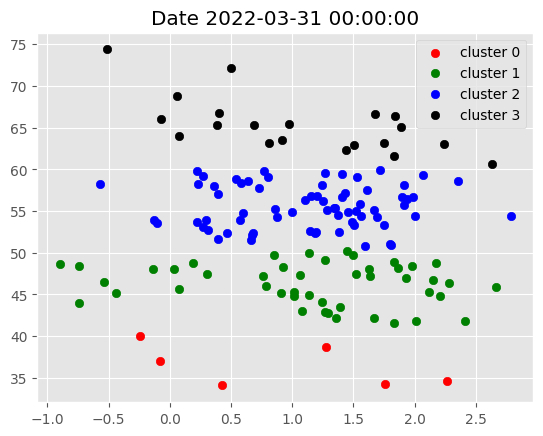

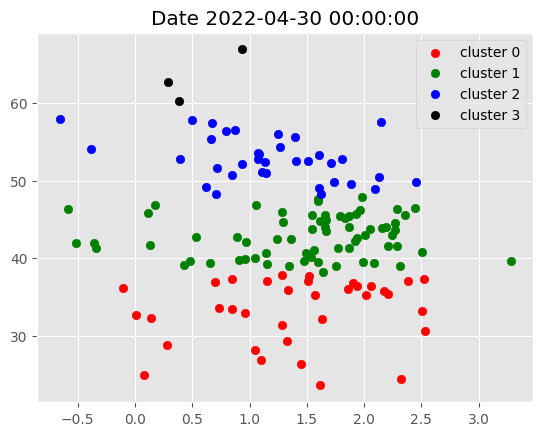

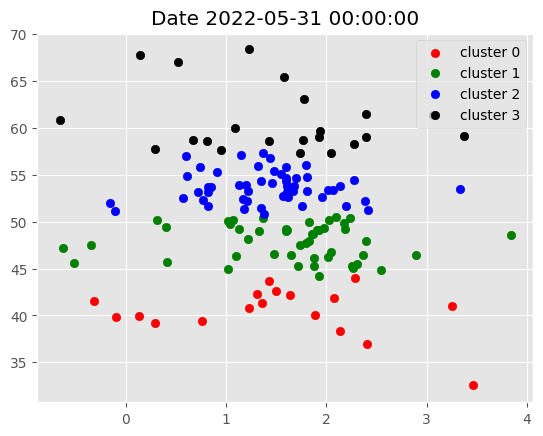

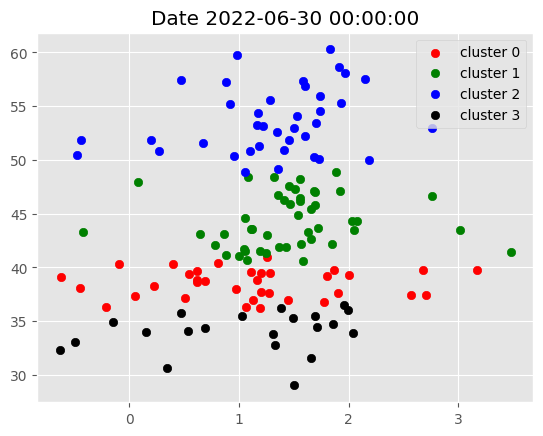

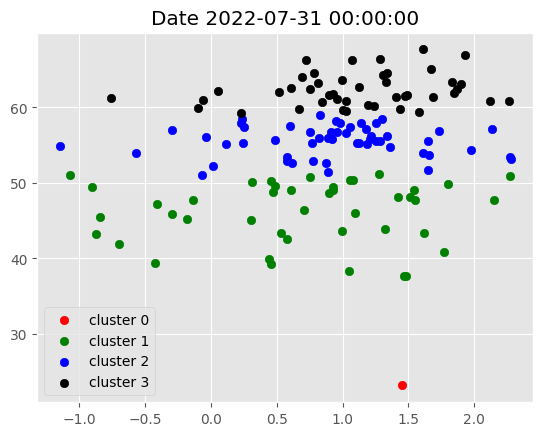

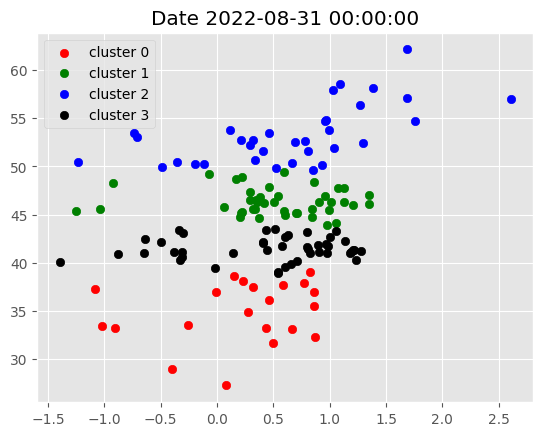

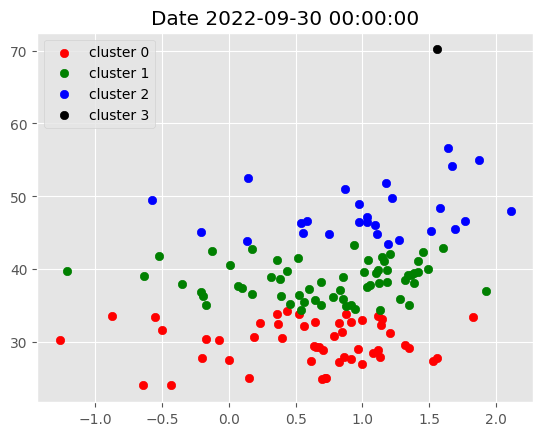

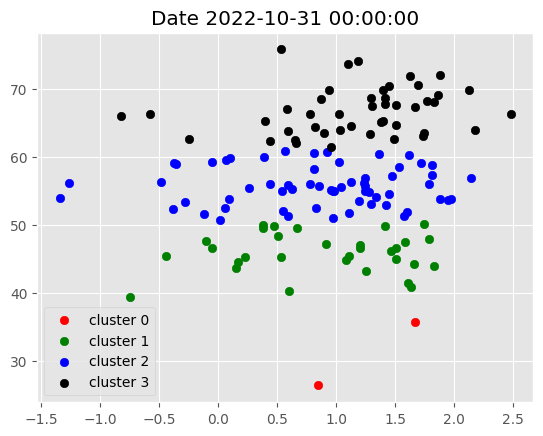

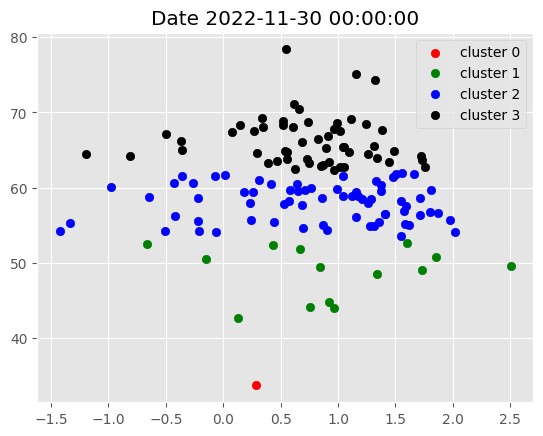

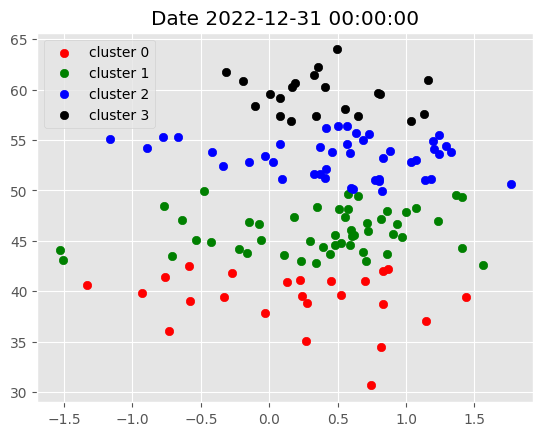

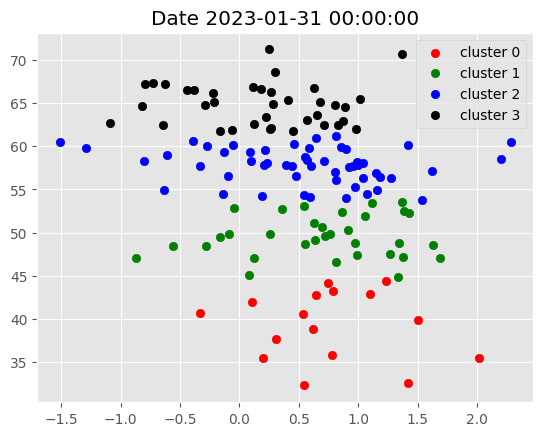

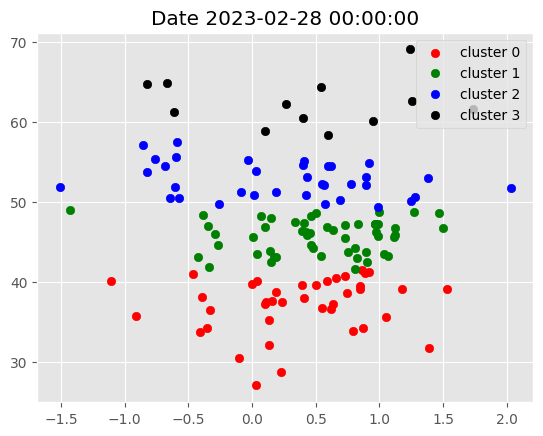

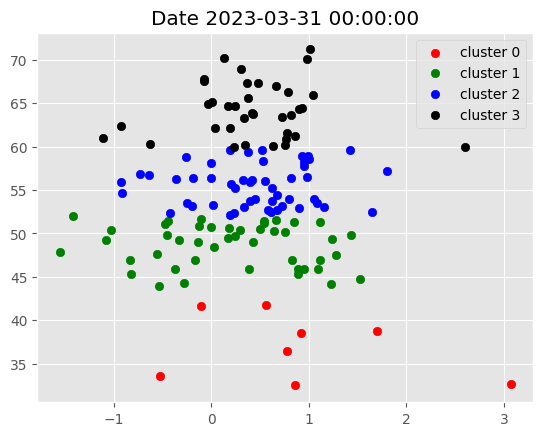

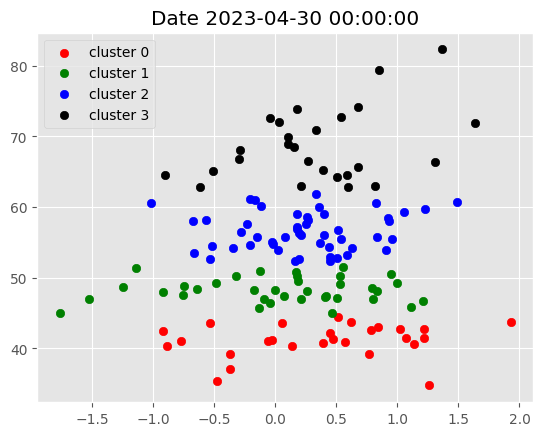

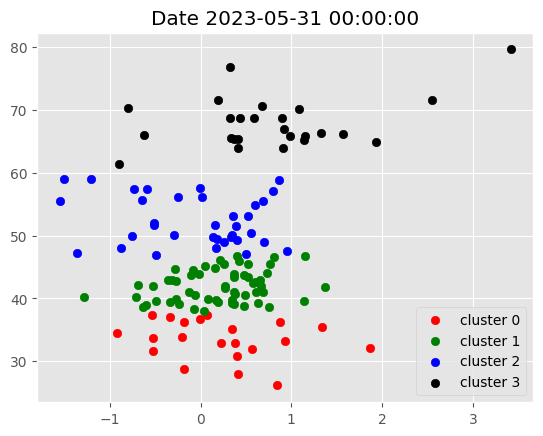

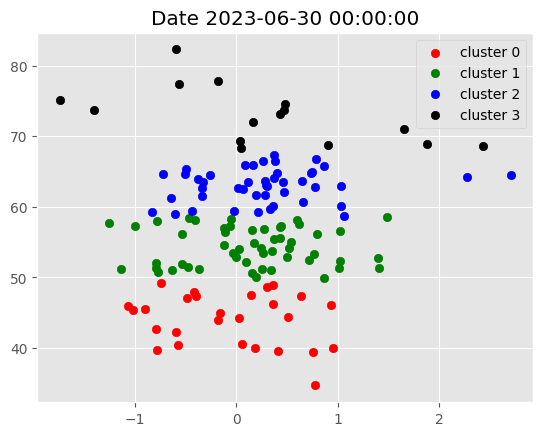

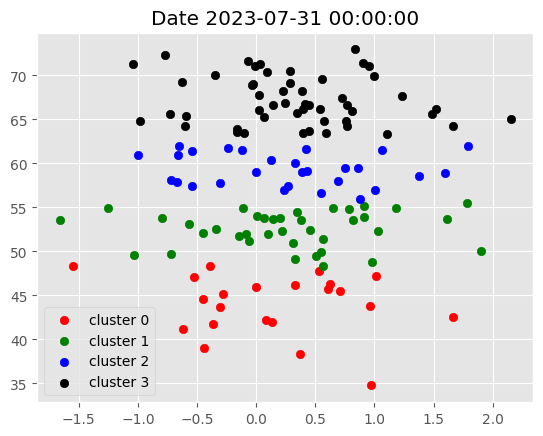

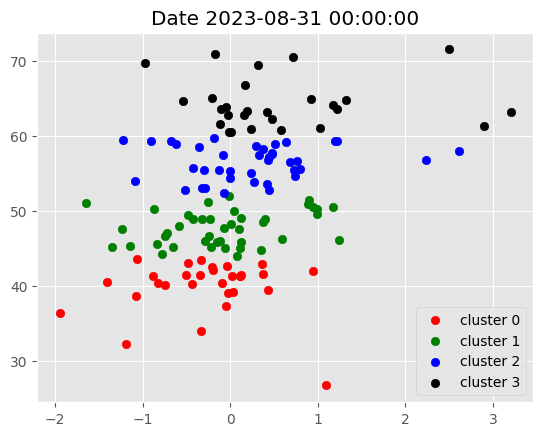

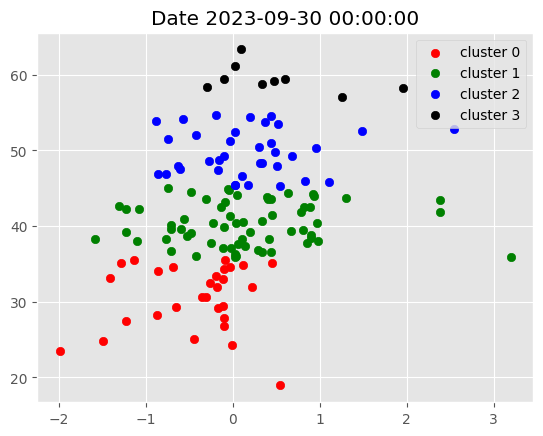

In [315]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

### 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [316]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MPC',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['BA',
  'CAT',
  'CVX',
  'DE',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG'

Define portfolio optimization function

We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [317]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

Download Fresh Daily Prices Data only for short listed stocks.

In [318]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                          ...    Volume                   
Ticker            AAL        AAPL        ABBV  ...       WMT     WYNN       XOM
Date                                           ...                             
2016-10-31  39.134327   26.212475   39.878788  ...  19167000  1341600  16663800
2016-11-01  38.363209   25.739204   40.357796  ...  26515800  3722300  13050600
2016-11-02  38.276455   25.762287   40.600876  ...  22935900  2542400  11226100
2016-11-03  38.054207   25.486153   39.957428  ...  20411700  9050400   8836500
2016-11-04  38.402088   25.256420   40.064663  ...  21786300  3223800  13877100
...               ...         ...         ...  ...       ...      ...       ...
2023-09-25  12.910000  175.386353  148.897156  ...  10459500  1387800  11316000
2023-09-26  12.700000  171.282578  148.184677  ...  14435700  1454000  11805400
2023-09-27  12.610000  169.758591  147.433685  ...  15711000  2050000  23976200
2023-09-28  12.920000  170.017578  146.586441  ...  11617200  1290400  16808100
2023-09-29  12.810000  170.535538  143.515091  ...  18842400  1326800  18810700

[1740 rows x 930 columns]

Calculate daily returns for each stock which could land up in our portfolio.

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculated each day portfolio return.

In [367]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-10-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.001481
2017-11-02,0.003027
2017-11-03,0.006364
2017-11-06,0.002789
2017-11-07,0.003079
...,...
2023-09-25,0.003459
2023-09-26,-0.012075
2023-09-27,0.004926


8. Visualize Portfolio returns and compare to SP500 returns.

In [368]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001481,0.001321
2017-11-02,0.003027,0.000388
2017-11-03,0.006364,0.003333
2017-11-06,0.002789,0.001546
2017-11-07,0.003079,-0.000696
...,...,...
2023-09-25,0.003459,0.004196
2023-09-26,-0.012075,-0.014800
2023-09-27,0.004926,0.000399
2023-09-28,0.008140,0.005781


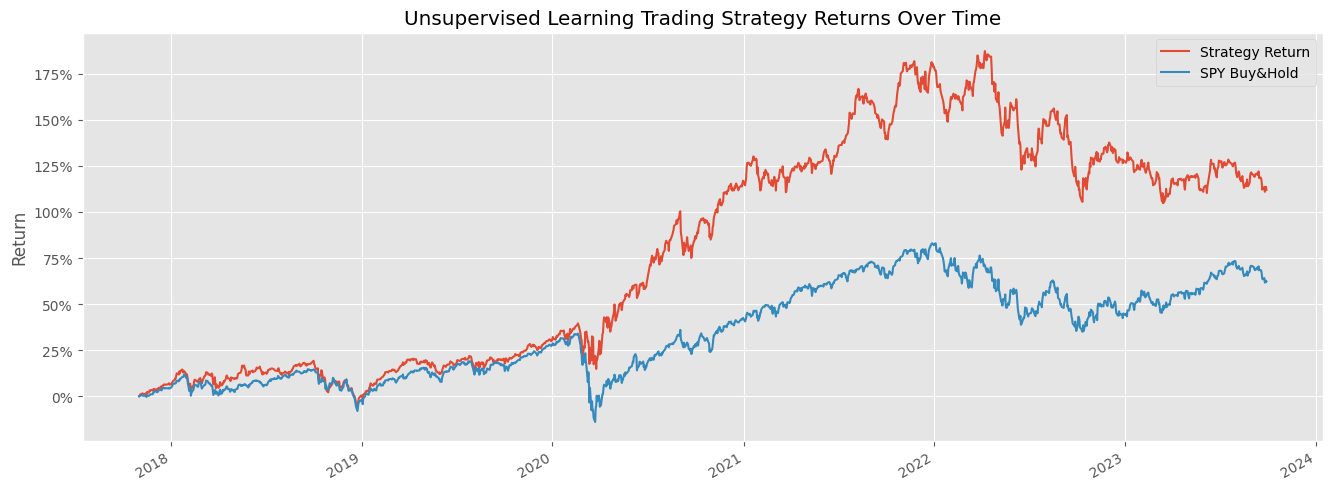

In [369]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()